In [1]:
import os
import numpy as np
from PIL import Image
import random

def load_and_preprocess_images(directory, target_size=(64, 128)):
    rows = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                try:
                    image = Image.open(image_path).convert('RGB')
                    image_resized = image.resize(target_size)

                    for row in np.array(image_resized):
                        rows.append((label, np.array(row, dtype=np.float32) / 255.0))
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

    return rows

train_rows = load_and_preprocess_images("train_dataset", target_size=(64, 128))
test_rows = load_and_preprocess_images("test_dataset", target_size=(64, 128))

In [2]:
def evaluate_model(model, test_rows):
    test_rows = list(test_rows)
    random.shuffle(test_rows)
    rows_iter = iter(test_rows)

    num_total = 0
    num_match = 0
    while True:
        labels = []
        rows = []

        try:
            while len(labels) < 128:
                label, row = next(rows_iter)
                labels.append(1.0 if label == "purple" else 0.0)
                rows.append(row)
        except StopIteration:
            break

        labels = torch.Tensor(labels).unsqueeze(-1)
        rows = torch.Tensor(rows).reshape(128, -1)

        result = model(rows)
        result = torch.nn.functional.sigmoid(result)

        labels = labels == 1        
        result = result > 0.5
        num_total += len(result)
        num_match += (labels == result).sum().item()
    
    return f"{(num_match / num_total) * 100}%"

In [3]:
import torch
import random

model = torch.nn.Sequential(
    torch.nn.Linear(64*3, 64),
    torch.nn.Sigmoid(),
    torch.nn.Linear(64, 1)
    # Skipping last Sigmoid here because BCEWithLogitsLoss requires it
)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for i in range(9):
    total_loss = 0
    steps = 0

    random.shuffle(train_rows)
    rows_iter = iter(train_rows)

    while True:
        labels = []
        rows = []

        try:
            while len(labels) < 128:
                label, row = next(rows_iter)
                labels.append(1.0 if label == "purple" else 0.0)
                rows.append(row)
        except StopIteration:
            break

        labels = torch.Tensor(labels).unsqueeze(-1)
        rows = torch.Tensor(rows).reshape(128, -1)

        optimizer.zero_grad()
        result = model(rows)
        loss = loss_fn(result, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps += 1

    print(f"Epoch {i} loss {total_loss / steps}, test accuracy {evaluate_model(model, test_rows)}")

/tmp/ipykernel_36916/3908306340.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  rows = torch.Tensor(rows).reshape(128, -1)


Epoch 0 loss 0.5068624645848817, test accuracy 98.515625%
Epoch 1 loss 0.2280465356911285, test accuracy 98.984375%
Epoch 2 loss 0.13490827551370935, test accuracy 99.375%
Epoch 3 loss 0.10098359747966633, test accuracy 99.609375%
Epoch 4 loss 0.08342640266954145, test accuracy 99.21875%
Epoch 5 loss 0.07308692923640903, test accuracy 99.296875%
Epoch 6 loss 0.0673607843161761, test accuracy 99.609375%
Epoch 7 loss 0.0617300364177061, test accuracy 99.6875%
Epoch 8 loss 0.05798559951819951, test accuracy 99.53125%


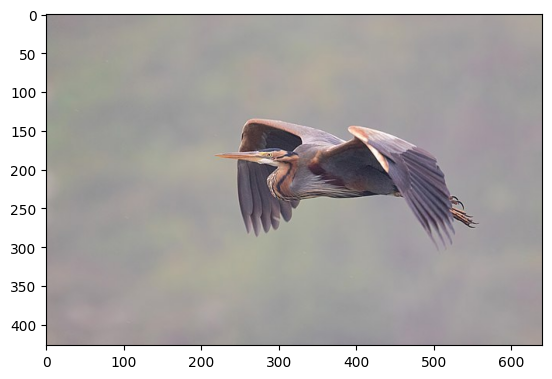

In [4]:
image = Image.open("test_dataset/nonpurple/Dropped Image (6).png").convert('RGB')

from matplotlib.pyplot import imshow
imshow(np.array(image))

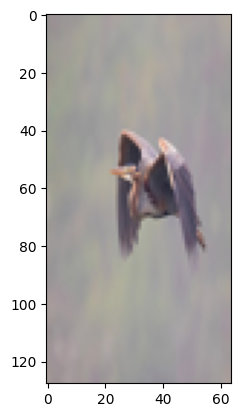

In [5]:
image = image.resize((64, 128))

imshow(np.array(image))

0.046908833
(128, 64)


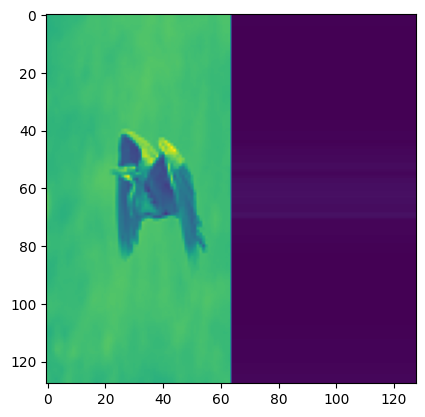

In [6]:
result = model(torch.Tensor(np.array(image)).reshape(128, -1) / 255.0)
result = torch.nn.functional.sigmoid(result)
result = result.detach().numpy()

result = result.repeat(64).reshape(128, 64)
print(result.max())
print(result.shape)
imshow(
    np.array([(np.array(image)/255.0).sum(axis=-1)/3.0, result]).transpose(1, 0, 2).reshape(128, 128)
)

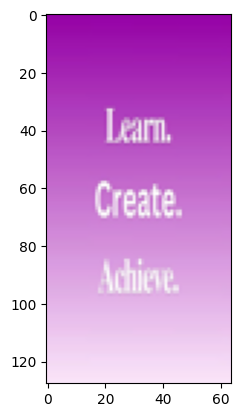

In [7]:
image = Image.open("test_dataset/purple/Dropped Image (6).png").convert('RGB').resize((64, 128))
imshow(np.array(image))

0.9997695
(128, 64)


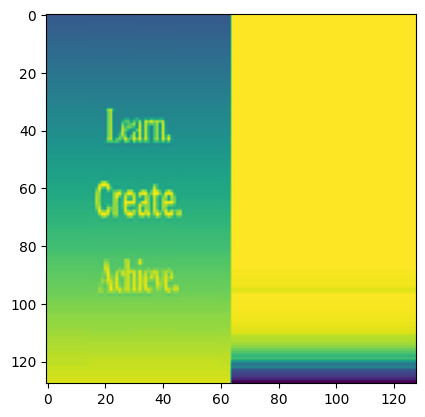

In [8]:
result = model(torch.Tensor(np.array(image)).reshape(128, -1) / 255.0)
result = torch.nn.functional.sigmoid(result)
result = result.detach().numpy()

result = result.repeat(64).reshape(128, 64)
print(result.max())
print(result.shape)
imshow(
    np.array([(np.array(image)/255.0).sum(axis=-1)/3.0, result]).transpose(1, 0, 2).reshape(128, 128)
)

In [9]:
torch.save(model.state_dict(), "weights.pt")